# Import Packages

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

#from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

# Load Dataset and Merge Table

In [2]:
#load dataset 
train_transaction = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/train_transaction.csv")
test_transaction = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/test_transaction.csv")
train_identity = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/train_identity.csv")
test_identity = pd.read_csv("/Users/wangjiaxin/Desktop/semester/data science for business/project/test_identity.csv")
#merge table
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction,test_identity, on = 'TransactionID', how = 'left')
# change some format of the columns name of test set
test= test.rename(columns=lambda x:"_".join(x.split("-")))

print('train:',train.shape)
print('test:', test.shape)

train: (590540, 434)
test: (506691, 433)


In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#target value
c = dict(train['isFraud'].value_counts())
c

{0: 569877, 1: 20663}

# Dealing with missing value

In [6]:
#dealing with missing value
def check_value(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% Missing'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% Missing', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [7]:
Missing_values_table_train = check_value(train)
train_null_tables= Missing_values_table_train.loc[Missing_values_table_train['% Missing'] > 90]
train_null_tables['Unique'] = [train[col].nunique() for col in train_null_tables.index ]
print (train_null_tables)

Missing_values_table_test = check_value(test)
test_null_tables= Missing_values_table_test.loc[Missing_values_table_test['% Missing'] > 90]
test_null_tables['Unique'] = [test[col].nunique() for col in test_null_tables.index ]
print (test_null_tables)

Your selected dataframe has 434 columns and 590540 Rows.
There are 414 columns that have missing values.
       Zero Values  Missing Values  % Missing Data Type  Unique
id_24            0          585793       99.2   float64      12
id_25            0          585408       99.1   float64     341
id_07          409          585385       99.1   float64      84
id_08          261          585385       99.1   float64      94
id_21            0          585381       99.1   float64     490
id_26            0          585377       99.1   float64      95
id_27            0          585371       99.1    object       2
id_23            0          585371       99.1    object       3
id_22            0          585371       99.1   float64      25
dist2         3519          552913       93.6   float64    1751
D7           21135          551623       93.4   float64     597
id_18            0          545427       92.4   float64      18
Your selected dataframe has 433 columns and 506691 Rows.
There 

In [8]:
#drop columns with more than 90% missing values
train = train.drop(columns = ['id_24','id_25','id_07','id_08','id_21','id_26','id_27','id_23','id_22','dist2','D7','id_18'])
test = test.drop(columns = ['id_24','id_25','id_07','id_08','id_21','id_26','id_27','id_23','id_22','dist2','D7','id_18'])

In [9]:
#dealing with numeric data, fill in with mean 
for col in train:
    if train[col].dtype != 'object':
        train[col] = train[col].fillna(train[col].mean())

for col in test:
    if test[col].dtype != 'object':
        test[col] = test[col].fillna(test[col].mean())
    
#dealing with categorical data, fill in with mode
for col in train:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode().iloc[0])

for col in test:
    if test[col].dtype == 'object':
        test[col] = test[col].fillna(test[col].mode().iloc[0])


In [10]:
print('missing values in training data set :', train.isnull().sum())
print('missing values in testing data set :', test.isnull().sum())

missing values in training data set : TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
                 ..
id_36             0
id_37             0
id_38             0
DeviceType        0
DeviceInfo        0
Length: 422, dtype: int64
missing values in testing data set : TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
                 ..
id_36             0
id_37             0
id_38             0
DeviceType        0
DeviceInfo        0
Length: 421, dtype: int64


# Reudece memory usage

In [11]:
#reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 630.20 Mb (66.9% reduction)
Mem. usage decreased to 547.97 Mb (66.4% reduction)


# Dealing with categorical data

In [13]:
#label encoder to make the categorical data suitable for the machine learning
for f in train.columns:
    if train[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values))
        train[f] = lbl.transform(list(train[f].values)) 
        
for f in test.columns:
    if test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(test[f].values))
        test[f] = lbl.transform(list(test[f].values))

# Split data set

In [14]:
#split the training dataset
y = train["isFraud"]
X = train.drop(["isFraud"], axis=1)

# 30% for testing, 70% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Decision Tree Classifier

In [35]:
#decision tree classifier
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train,y_train)
predict_y_dt = model.predict(X_test)
predict_y_dt_prob = model.predict_proba(X_test)

In [36]:
accuracy_score_dt=accuracy_score(y_test,predict_y_dt)
f1_score_dt=f1_score(y_test,predict_y_dt)
roc_auc_score_dt=roc_auc_score(y_test,predict_y_dt)

print('Accuracy score:',accuracy_score_dt)
print('F1 score:',f1_score_dt)
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score_dt)
print('Confusion maxtrix',confusion_matrix(y_test,predict_y_dt))

Accuracy score: 0.9676567209672503
F1 score: 0.559095106186519
Area Under the Receiver Operating Characteristic Curve: 0.7837776698540234
Confusion maxtrix [[167799   3164]
 [  2566   3633]]


# Random forest classifier

In [19]:
#random forest classifier
forest = RandomForestClassifier(criterion='entropy',random_state=50,n_estimators=100,)
forest.fit(X_train,y_train)
predict_y_rf = forest.predict(X_test)
predict_y_rf_prob = forest.predict_proba(X_test)

In [20]:
accuracy_score_rf=accuracy_score(y_test,predict_y_rf)
f1_score_rf=f1_score(y_test,predict_y_rf)
roc_auc_score_rf=roc_auc_score(y_test,predict_y_rf)

print('Accuracy score:',accuracy_score_rf)
print('F1 score:',f1_score_rf)
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score_rf)
print('Confusion maxtrix',confusion_matrix(y_test,predict_y_rf))

Accuracy score: 0.9794877005226854
F1 score: 0.6004837291116976
Area Under the Receiver Operating Characteristic Curve: 0.7197919789436575
Confusion maxtrix [[170797    166]
 [  3468   2731]]


# Logistic Regression Classifier

In [21]:
#logistic regression classifier
logreg = LogisticRegression()
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(X_train,y_train)
predict_y_logistic=logreg.predict(X_test)
predict_y_logistic_prob=logreg.predict_proba(X_test)

In [22]:
accuracy_score_logistic=accuracy_score(y_test,predict_y_logistic)
f1_score_logistic=f1_score(y_test,predict_y_logistic)
roc_auc_score_logistic=roc_auc_score(y_test,predict_y_logistic)

print('Accuracy score:',accuracy_score_logistic)
print('F1 score:',f1_score_logistic)
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score_logistic)
print('Confusion maxtrix',confusion_matrix(y_test,predict_y_logistic))

Accuracy score: 0.9648344453099423
F1 score: 0.0032000000000000006
Area Under the Receiver Operating Characteristic Curve: 0.500686672720572
Confusion maxtrix [[170922     41]
 [  6189     10]]


In [23]:
#svm
#from sklearn import svm
#clf = svm.SVC() 
#clf.fit(X_train,y_train)
#predict_y_svm=clf.predict(X_test)

In [24]:
#accuracy_score_svm=accuracy_score(y_test,predict_y_svm)
#f1_score_svm=f1_score(y_test,predict_y_svm)
#roc_auc_score_svm=roc_auc_score(y_test,predict_y_svm)

#print('Accuracy score:',accuracy_score_svm)
#print('F1 score:',f1_score_svm)
#print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score_svm)
#print('Confusion maxtrix',confusion_matrix(y_test,predict_y_svm))

In [25]:
#neural network

# Comparing

In [37]:
predict_y_dt_prob = pd.DataFrame(predict_y_dt_prob)
predict_y_dt_prob = np.array(predict_y_dt_prob[1])
predict_y_dt_prob

array([0., 0., 0., ..., 0., 0., 0.])

In [38]:
predict_y_rf_prob = pd.DataFrame(predict_y_rf_prob)
predict_y_rf_prob = np.array(predict_y_rf_prob[1])
predict_y_logistic_prob = pd.DataFrame(predict_y_logistic_prob)
predict_y_logistic_prob = np.array(predict_y_logistic_prob[1])

In [39]:
#compare with different models
#predic_y
pred_df= pd.DataFrame({'Decision Tree':predict_y_dt_prob,'Random Forest':predict_y_rf_prob,'Logistic Regression':predict_y_logistic_prob})
pred_df.head()

,Decision Tree,Random Forest,Logistic Regression
0,0.0,0.03,0.032305
1,0.0,0.00,0.040168
2,0.0,0.02,0.031451
3,0.0,0.06,0.031731
4,0.0,0.01,0.033229


In [40]:
#evaluate
evaluate={'model_name':['Decision Tree','Random Forest','Logistic Regression'],
         'Accuracy_Score':[accuracy_score_dt,accuracy_score_rf,accuracy_score_logistic],
         'F1_Score':[f1_score_dt,f1_score_rf,f1_score_logistic],
         'ROC_AUC_Score':[roc_auc_score_dt,roc_auc_score_rf,roc_auc_score_logistic]}
pred_df_evaluate=pd.DataFrame(evaluate)
pred_df_evaluate

,model_name,Accuracy_Score,F1_Score,ROC_AUC_Score
0,Decision Tree,0.967657,0.559095,0.783778
1,Random Forest,0.979488,0.600484,0.719792
2,Logistic Regression,0.964834,0.003200,0.500687


In [41]:
# test-use model
#y_preds = forest.predict_proba(test)
#sub_rf = pd.DataFrame({
#    'TransactionID' : sub.TransactionID,
#    'isFraud' : y_preds[:,1]
#})
#sub_rf.head()

# Business Part

In [42]:
#table_print=X_test
#table_print

In [43]:
#predict_y_dt_list=list(predict_y_dt)
#predict_y_rf_list=list(predict_y_rf)
#predict_y_logistic_list=list(predict_y_logistic)
#table_print['predict_y_dt']=predict_y_dt_list
#table_print['predict_y_rf']=predict_y_rf_list
#table_print['predict_y_logistic']=predict_y_logistic_list
#table_print.head()

In [44]:
#import os  
#os.makedirs('/Users/wangjiaxin/Desktop/semester/data science for business/project', exist_ok=True)  
#table_print.to_csv('/Users/wangjiaxin/Desktop/semester/data science for business/project/table_print.csv')  

In [54]:
df_bz=X_test[['TransactionID','TransactionAmt']]
df_bz['isfraud']=y_test
df_bz['predict_y_dt']=predict_y_dt_prob
df_bz['predict_y_rf']=predict_y_rf_prob
df_bz['predict_y_logistic']=predict_y_logistic_prob
df_bz

,TransactionID,TransactionAmt,isfraud,predict_y_dt,predict_y_rf,predict_y_logistic
274635,3261635,29.359375,0,0.0,0.03,0.032305
115501,3102501,25.000000,0,0.0,0.00,0.040168
387765,3374765,57.937500,0,0.0,0.02,0.031451
123591,3110591,119.750000,0,0.0,0.06,0.031731
462833,3449833,107.937500,0,0.0,0.01,0.033229
...,...,...,...,...,...,...
34270,3021270,594.000000,0,1.0,0.02,0.034959
47126,3034126,58.812500,0,0.0,0.04,0.029757
446397,3433397,30.953125,0,0.0,0.00,0.029956
254641,3241641,87.937500,0,0.0,0.01,0.036024


In [56]:
#1.Take no action 
#2.Send the user an email or SMS telling them about the transaction and asking them to contact their financial institution if they did not authorize the transaction 
#3.Prompt the member for the second form of authentication before allowing the transaction to process
#4.Block the transaction and disable the user's credit card until they can prove their identity on a call
df_bz['predict_y_dt_amount']=df_bz['TransactionAmt']*df_bz['predict_y_dt']
df_bz['predict_y_rf_amount']=df_bz['TransactionAmt']*df_bz['predict_y_rf']
df_bz['predict_y_logistic_amount']=df_bz['TransactionAmt']*df_bz['predict_y_logistic']
df_bz



,TransactionID,TransactionAmt,isfraud,predict_y_dt,predict_y_rf,predict_y_logistic,predict_y_dt_amount,predict_y_rf_amount,predict_y_logistic_amount
274635,3261635,29.359375,0,0.0,0.03,0.032305,0.0,0.880781,0.948453
115501,3102501,25.000000,0,0.0,0.00,0.040168,0.0,0.000000,1.004195
387765,3374765,57.937500,0,0.0,0.02,0.031451,0.0,1.158750,1.822170
123591,3110591,119.750000,0,0.0,0.06,0.031731,0.0,7.185000,3.799812
462833,3449833,107.937500,0,0.0,0.01,0.033229,0.0,1.079375,3.586607
...,...,...,...,...,...,...,...,...,...
34270,3021270,594.000000,0,1.0,0.02,0.034959,594.0,11.880000,20.765800
47126,3034126,58.812500,0,0.0,0.04,0.029757,0.0,2.352500,1.750085
446397,3433397,30.953125,0,0.0,0.00,0.029956,0.0,0.000000,0.927224
254641,3241641,87.937500,0,0.0,0.01,0.036024,0.0,0.879375,3.167898


       TransactionID  TransactionAmt      isfraud  predict_y_dt  predict_y_rf  \
count   6.797000e+03     6797.000000  6797.000000        6797.0   6797.000000   
mean    3.292146e+06             inf     0.534501           1.0      0.396610   
std     1.692652e+05             inf     0.498845           0.0      0.356277   
min     2.987075e+06        0.291992     0.000000           1.0      0.000000   
25%     3.151780e+06       34.500000     0.000000           1.0      0.060000   
50%     3.288839e+06       73.250000     1.000000           1.0      0.280000   
75%     3.432210e+06      161.000000     1.000000           1.0      0.750000   
max     3.577529e+06     5420.000000     1.000000           1.0      1.000000   

       predict_y_logistic  predict_y_dt_amount  predict_y_rf_amount  \
count         6797.000000          6797.000000          6797.000000   
mean             0.041040           153.593115            49.604219   
std              0.038087           258.777643           

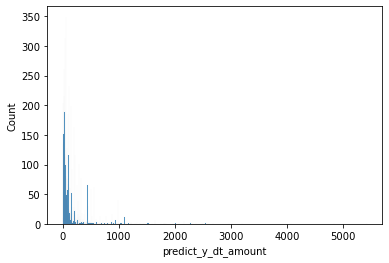

In [57]:
import seaborn as sns
predict_y_dt_amount=df_bz[df_bz['predict_y_dt_amount']>0]
sns.histplot(data=predict_y_dt_amount, x="predict_y_dt_amount", binwidth=3)
print(predict_y_dt_amount.describe())

       TransactionID  TransactionAmt       isfraud  predict_y_dt  \
count   9.802900e+04    98029.000000  98029.000000  98029.000000   
mean    3.285938e+06             NaN      0.060829      0.065909   
std     1.708108e+05             NaN      0.239017      0.248124   
min     2.987001e+06        0.291992      0.000000      0.000000   
25%     3.140622e+06       42.562500      0.000000      0.000000   
50%     3.285529e+06       77.000000      0.000000      0.000000   
75%     3.433327e+06      150.000000      0.000000      0.000000   
max     3.577539e+06     5420.000000      1.000000      1.000000   

       predict_y_rf  predict_y_logistic  predict_y_dt_amount  \
count  98029.000000        9.802900e+04         98029.000000   
mean       0.064565        3.598839e-02            10.214512   
std        0.143383        2.082042e-02            77.444300   
min        0.010000        9.937675e-10             0.000000   
25%        0.010000        2.930046e-02             0.000000   
50%

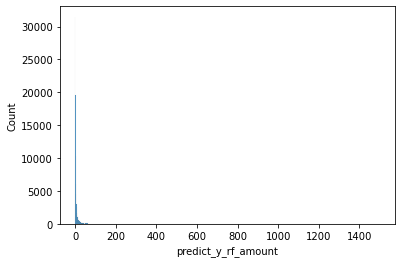

In [58]:
predict_y_rf_amount=df_bz[df_bz['predict_y_rf_amount']>0]
sns.histplot(data=predict_y_rf_amount, x="predict_y_rf_amount", binwidth=1)
print(predict_y_rf_amount.describe())

In [62]:
### TODO: AMOUNT
df_bz['predict_y_dt_action']=np.where(df_bz['predict_y_dt']>=0.9,'Blocked',
                                      np.where(df_bz['predict_y_dt']>=0.75,'TwoFA',
                                      np.where(df_bz['predict_y_dt']>=0.5,'Alert','No_Action')))
df_bz['predict_y_rf_action']=np.where(df_bz['predict_y_rf']>=0.9,'Blocked',
                                      np.where(df_bz['predict_y_rf']>=0.75,'TwoFA',
                                      np.where(df_bz['predict_y_rf']>=0.5,'Alert','No_Action')))
df_bz['predict_y_logistic_action']=np.where(df_bz['predict_y_logistic']>=0.9,'Blocked',
                                      np.where(df_bz['predict_y_logistic']>=0.75,'TwoFA',
                                      np.where(df_bz['predict_y_logistic']>=0.5,'Alert','No_Action')))

df_bz

,TransactionID,TransactionAmt,isfraud,predict_y_dt,predict_y_rf,predict_y_logistic,predict_y_dt_amount,predict_y_rf_amount,predict_y_logistic_amount,predict_y_dt_action,predict_y_rf_action,predict_y_logistic_action
274635,3261635,29.359375,0,0.0,0.03,0.032305,0.0,0.880781,0.948453,No_Action,No_Action,No_Action
115501,3102501,25.000000,0,0.0,0.00,0.040168,0.0,0.000000,1.004195,No_Action,No_Action,No_Action
387765,3374765,57.937500,0,0.0,0.02,0.031451,0.0,1.158750,1.822170,No_Action,No_Action,No_Action
123591,3110591,119.750000,0,0.0,0.06,0.031731,0.0,7.185000,3.799812,No_Action,No_Action,No_Action
462833,3449833,107.937500,0,0.0,0.01,0.033229,0.0,1.079375,3.586607,No_Action,No_Action,No_Action
...,...,...,...,...,...,...,...,...,...,...,...,...
34270,3021270,594.000000,0,1.0,0.02,0.034959,594.0,11.880000,20.765800,Blocked,No_Action,No_Action
47126,3034126,58.812500,0,0.0,0.04,0.029757,0.0,2.352500,1.750085,No_Action,No_Action,No_Action
446397,3433397,30.953125,0,0.0,0.00,0.029956,0.0,0.000000,0.927224,No_Action,No_Action,No_Action
254641,3241641,87.937500,0,0.0,0.01,0.036024,0.0,0.879375,3.167898,No_Action,No_Action,No_Action


In [63]:
df_bz['predict_y_dt_action'].value_counts()

No_Action    170365
Blocked        6797
Name: predict_y_dt_action, dtype: int64

In [64]:
df_bz['predict_y_rf_action'].value_counts()

No_Action    174204
Alert          1159
Blocked         998
TwoFA           801
Name: predict_y_rf_action, dtype: int64

In [65]:
df_bz['predict_y_logistic_action'].value_counts()

No_Action    177111
Alert            29
TwoFA            11
Blocked          11
Name: predict_y_logistic_action, dtype: int64

In [75]:
#retention decrease--random forest
def get_retention_decrease(df):
    #Take No Action, and there was no fraud
    if df['isfraud']==0 & df['predict_y_rf_action']=='No_Action':
        return 0
    #Take No Action, but there was fraud
    if df['isfraud']==1 & df['predict_y_rf_action']=='No_Action':
        return 0.75
    #IF ResponseAction = Alert AND Fraud = 0 THEN (Count + 1) AND (IdvAvgRetentionDec = 0)
    if df['isfraud']==0 & df['predict_y_rf_action']=='Alert':
        return 0
    #IF ResponseAction = Alert AND Fraud = 1 THEN (Count + 1) AND (IdvAvgRetentionDec = .2)
    if df['isfraud']==1 & df['predict_y_rf_action']=='Alert':
        return 0.2
    #IF ResponseAction = TwoFA AND Fraud = 0 THEN (Count + 1) AND (IdvAvgRetentionDec = .03)
    if df['isfraud']==0 & df['predict_y_rf_action']=='TwoFA':
        return 0.03
    #IF ResponseAction = TwoFA AND Fraud = 1 THEN (Count + 1) AND (IdvAvgRetentionDec = 0)
    if df['isfraud']==1 & df['predict_y_rf_action']=='TwoFA':
        return 0
    #IF ResponseAction = Blocked AND Fraud = 0 THEN (Count + 1) AND (IdvAvgRetentionDec = .50)
    if df['isfraud']==0 & df['predict_y_rf_action']=='Blocked':
        return 0.5
    #IF ResponseAction = Blocked AND Fraud = 1 THEN (Count + 1) AND (IdvAvgRetentionDec = .03)
    if df['isfraud']==1 & df['predict_y_rf_action']=='Blocked':
        return 0.03

In [81]:
df_bz["retention_dec"] = ""

dtype('int8')

In [86]:
df_bz["retention_dec"] = df_bz.apply(get_retention_decrease)

KeyError: 'isfraud'